In [1]:
#Runs successfully on MBP 2024 metal_102 conda environment.
import numpy as np
import torch
import torch.nn as nn
import pymc as pm
from pymc.util import get_value_vars_from_user_vars
import arviz as az
import pytensor.tensor as tt
from pytensor import scan
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
# Suppress PyTorch warnings
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # Use CPU instead of GPU
print(pm.__version__)

5.12.0


In [2]:
import cProfile
import pstats

def profile_func(func):
    def wrapper(*args, **kwargs):
        profiler = cProfile.Profile()
        result = profiler.runcall(func, *args, **kwargs)
        stats = pstats.Stats(profiler).sort_stats('cumulative')
        stats.print_stats(20)  # Print top 20 time-consuming operations
        return result
    return wrapper

In [3]:
# Define constants
SIZE = 200
T=200
dt=0.1
NUM_SAMPLES = 100
EPOCHS = 1000
DEBUG = False

In [ ]:
import pymc as pm
from pymc.step_methods import CompoundStep, Metropolis
import numpy as np
import pytensor.tensor as pt
import torch
class CustomGANStep(CompoundStep):
    def __init__(self, model, discriminator, T=200, dt=0.1, debug=False):
        #print("\nEntering CustomGANStep.__init__")
        
        # Get the free random variables from the model
        vars = [model['kc12'], model['kc21'], model['Fnoise'], model['scale'], model['offset'], 
                model['kco1'], model['koc2'], model['ko12'], model['ko21']]
        self.can_be_negative = ['offset']
        metropolis_steps = [Metropolis([var]) for var in vars]
        
        # Initialize CompoundStep with these Metropolis steps
        super().__init__(metropolis_steps)

        # Store additional information in a dictionary
        self.gan_info = {
            'discriminator': discriminator,
            'T': T,
            'dt': dt,
            'vars': vars,
            'var_names': [var.name for var in vars]
        }

        self.debug = debug
        if self.debug:
            print(f"Initialized CustomGANStep with variables: {self.gan_info['var_names']}")
            
    def step(self, point):
        #print("Step function")
        q = []
        q_original = []
        for var in self.vars:
            if self.debug:
                print(f"Processing variable: {var.name}")
                pint(f"Variable type: {type(var)}")
                #print(f"Distribution: {var.distribution}")
            if var.name in point:
                #print("var.name in point")
                value = point[var.name]
                #print("pt value:", value)
            else:
                print("var.name not in point")
                matching_key = next((k for k in point.keys() if k.startswith(var.name)), None)
                if matching_key:
                    value = point[matching_key]
                    #print("matching value:", value)
                else:
                    raise KeyError(f"Cannot find a matching key for variable {var.name}")            
            try:
                q.append(10**value)  # This is the transformed value
                #q_original.append(var.distribution.transform.backward(value).eval())  # This is the original scale value
            except Exception as e:
                print(f"Error processing variable {var.name}: {str(e)}")
                raise
        
        if self.debug:
            print(f"Current params (transformed): {q}")
            #print(f"Current params (original scale): {q_original}")

        q_new = self.proposal(q)
        q_new_original = []
        """
        for var, val in zip(self.gan_info['vars'], q_new):
            q_new_original.append(var.distribution.transform.backward(val).eval())"""

        if self.debug:
            print(f"Proposed params (transformed): {q_new}")
            #print(f"Proposed params (original scale): {q_new_original}")

        synthetic_data_current = self.generate_synthetic_data(q)
        synthetic_data_proposed = self.generate_synthetic_data(q_new)

        current_disc_score = self.get_discriminator_score(synthetic_data_current)
        proposed_disc_score = self.get_discriminator_score(synthetic_data_proposed)
        if self.debug:
            print(f"current Disc score = {current_disc_score}, proposed = {proposed_disc_score}")

        accept = self.compute_acceptance(point, q_new, current_disc_score, proposed_disc_score)
        #print("accept=",accept)
        accept_prob = float(accept)
        #print("accept prob", accept_prob)
        
        if np.random.random() < accept_prob:
            for var, val in zip(self.gan_info['vars'], q_new):
                if var.name in point:
                    point[var.name] = np.atleast_1d(val)
                else:
                    matching_key = next(k for k in point.keys() if k.startswith(var.name))
                    point[matching_key] = np.atleast_1d(val)

        return point, {}

    def proposal(self, q):
        new_q = []
        for i, (val, var_name) in enumerate(zip(q, self.gan_info['var_names'])):
            if var_name in self.can_be_negative:
                # For parameters that can be negative (like offset)
                proposed_val = val + np.random.normal(0, 0.1 * (np.abs(val) + 1e-8))
            else:
                # For parameters that must be positive
                log_val = np.log(max(val, 1e-8))  # Ensure we don't take log of a negative number
                proposed_log_val = log_val + np.random.normal(0, 0.1)
                proposed_val = np.exp(proposed_log_val)
            new_q.append(proposed_val)
        return new_q

    def compute_acceptance(self, current_point, proposed_values, current_disc_score, proposed_disc_score):
        #print("Inside_compute acceptance()")
        current_logp = self.logp(current_point)
        #print("Current_logp", float(current_logp))
        
        proposed_point = current_point.copy()
        for var, val in zip(self.gan_info['vars'], proposed_values):
            if var.name in proposed_point:
                proposed_point[var.name] = val
            else:
                matching_key = next(k for k in proposed_point.keys() if k.startswith(var.name))
                proposed_point[matching_key] = val
        
        proposed_logp = self.logp(proposed_point)
        #print("proposed_logp", float(proposed_logp))
        
        # Metropolis-Hastings acceptance ratio
        ratio = np.exp(float(proposed_logp - current_logp))
    
        # Incorporate discriminator scores
        ratio = ratio * np.exp(proposed_disc_score - current_disc_score)
        #print("Ratio", float(ratio))
    
        return min(1, ratio)

    def generate_synthetic_data(self, params):
        if self.debug:
            print(f"Params passed to generate_synthetic_data: {params}")
        params = [float(p) for p in params]  # Convert to float
        return pymc_sim_channel(params, self.gan_info['T'], self.gan_info['dt'], source="torch")

    def get_discriminator_score(self, data):
        if isinstance(data, torch.Tensor):
            data_tensor = data.clone().detach().float().unsqueeze(0)
        else:
            data_tensor = torch.tensor(data).float().unsqueeze(0)
        with torch.no_grad():
            score = self.gan_info['discriminator'](data_tensor).item()
        return score
    
    def logp(self, point):
        logp_sum = 0
        for var in self.gan_info['vars']:
            if var.name in point:
                value = point[var.name]
            else:
                matching_key = next((k for k in point.keys() if k.startswith(var.name)), None)
                if matching_key:
                    value = point[matching_key]
                else:
                    raise KeyError(f"Cannot find a matching key for variable {var.name}")
            
            # Evaluate the logp symbolically and then get its value
            logp_val = pm.logp(var, value).eval()
            logp_sum += float(logp_val)
        return float(logp_sum)
        

In [82]:
# Define the discriminator model
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv1d(2, 64, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(),
            nn.Conv1d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(),
            nn.Flatten(),
            nn.Linear(128 * (SIZE // 4), 1)
        )

    def forward(self, x):
        return self.model(x.permute(0, 2, 1))

In [83]:
# Loss function for the discriminator
def discriminator_loss(real_output, fake_output):
    real_loss = nn.BCEWithLogitsLoss()(real_output, torch.ones_like(real_output))
    fake_loss = nn.BCEWithLogitsLoss()(fake_output, torch.zeros_like(fake_output))
    return real_loss + fake_loss

In [84]:
# Create and compile the discriminator
discriminator = Discriminator()
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)

In [101]:
import pytensor.tensor as tt
from pytensor.scan import scan
from pytensor.tensor.random.utils import RandomStream
import torch
import numpy as np

def pymc_sim_channel(params, T, dt, source="torch"):
    kc12, kc21, Fnoise, scale, offset, kco1, koc2, ko12, ko21 = params
    eps = 1e-10  # Small constant to avoid zero probabilities
    if source == "pymc":
        zero = tt.constant(0.0)
        one = tt.constant(1.0)
        
        # Convert parameters to PyTensor tensors
        """
        kc12, kc21, kco1, koc2, ko12, ko21, Fnoise, scale = map(tt.as_tensor_variable, 
                                                                        [kc12, kc21, kco1, koc2, ko12, ko21, Fnoise, scale])

        """
        kc12, kc21, kco1, koc2, ko12, ko21, Fnoise, scale = map(lambda x: tt.maximum(tt.as_tensor_variable(x), eps), 
                                                                [kc12, kc21, kco1, koc2, ko12, ko21, Fnoise, scale])
        # Create transition matrix
        row1 = tt.stack([1-kc12, kc12, zero, zero])
        row2 = tt.stack([kc21, 1-kc21-kco1, kco1, zero])
        row3 = tt.stack([zero, koc2, 1-koc2-ko12, ko12])
        row4 = tt.stack([zero, zero, ko21, 1-ko21])
        transition_matrix = tt.stack([row1, row2, row3, row4])

        transition_matrix = tt.maximum(transition_matrix, eps)
        row_sums = transition_matrix.sum(axis=1, keepdims=True)
        transition_matrix = transition_matrix / row_sums
        
        # Create a RandomStream for managing the RNG
        srng = RandomStream()
        
        # Generate random initial state
        initial_state = srng.categorical(tt.ones(4) / 4, size=(1,))
        
        def step(state, transition_probs):
            new_state = srng.categorical(transition_probs[state[0]], size=(1,))
            return new_state
        
        states, _ = scan(
            fn=step,
            outputs_info=initial_state,
            non_sequences=transition_matrix,
            n_steps=SIZE-1
        )
        
        states = tt.concatenate([initial_state, states.flatten()])
        
        # Convert states to channels
        channels = tt.switch(states < 2, zero, one)
        
        # Generate noise
        noise = srng.normal(0, Fnoise, size=(SIZE,))
        
        # Combine channels and noise
        result = tt.stack([channels, channels * scale + offset + noise], axis=-1)
        
        # Return the PyTensor variable directly
        return result

    else:
        # Convert to PyTorch tensors
        def to_torch_tensor(x):
            if isinstance(x, (np.ndarray, list)):
                return torch.tensor(np.clip(x, eps, None).astype(np.float32))
            else:
                return torch.tensor(float(x))  # Remove the max() for offset

        kc12, kc21, kco1, koc2, ko12, ko21, Fnoise, scale = map(lambda x: to_torch_tensor(max(x, eps)), 
                                                                [kc12, kc21, kco1, koc2, ko12, ko21, Fnoise, scale])
        offset = to_torch_tensor(offset)  # Don't apply max() to offset
        
        # Create transition matrix
        row1 = torch.stack([1-kc12, kc12, torch.zeros_like(kc12), torch.zeros_like(kc12)])
        row2 = torch.stack([kc21, 1-kc21-kco1, kco1, torch.zeros_like(kc21)])
        row3 = torch.stack([torch.zeros_like(koc2), koc2, 1-koc2-ko12, ko12])
        row4 = torch.stack([torch.zeros_like(ko21), torch.zeros_like(ko21), ko21, 1-ko21])
                
        transition_matrix = torch.stack([row1, row2, row3, row4])
        
        # Ensure non-negative values and add small constant
        transition_matrix = torch.clamp(transition_matrix, min=eps)
        
        # Normalize rows to sum to 1
        row_sums = transition_matrix.sum(dim=1, keepdim=True)
        transition_matrix = transition_matrix / row_sums
        
        def transition_fn(state):
            probs = transition_matrix[state]
            return torch.distributions.Categorical(probs=probs).sample()
        
        initial_probs = torch.ones(4) / 4  # Equal probability for all initial states
        initial_distribution = torch.distributions.Categorical(probs=initial_probs)
        
        states = [initial_distribution.sample().item()]
        
        for _ in range(T - 1):  # Use T instead of SIZE
            states.append(transition_fn(states[-1]).item())
        
        channels = torch.tensor(states)
        channels = torch.where(channels < 2, torch.zeros_like(channels), torch.ones_like(channels))
        noise = torch.normal(0, Fnoise, (T,))
        
        res = torch.stack([channels, channels * scale + offset + noise], axis=-1)
        return res

['T', '__abs__', '__abstractmethods__', '__add__', '__and__', '__annotations__', '__array_priority__', '__bool__', '__ceil__', '__class__', '__class_getitem__', '__count__', '__delattr__', '__dict__', '__dir__', '__div__', '__divmod__', '__doc__', '__dot__', '__eq__', '__floor__', '__floordiv__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__invert__', '__iter__', '__le__', '__lt__', '__matmul__', '__mod__', '__module__', '__mul__', '__ne__', '__neg__', '__new__', '__or__', '__orig_bases__', '__parameters__', '__pow__', '__radd__', '__rand__', '__rdiv__', '__rdivmod__', '__rdot__', '__reduce__', '__reduce_ex__', '__repr__', '__repr_test_value__', '__rfloordiv__', '__rmatmul__', '__rmod__', '__rmul__', '__ror__', '__rpow__', '__rsub__', '__rtruediv__', '__rxor__', '__setattr__', '__setitem__', '__sizeof__', '__slots__', '__str__', '__sub__', '__subclasshook__', '__truediv__', '__trunc__', '__weakref__

TypeError: object of type 'TensorVariable' has no len()

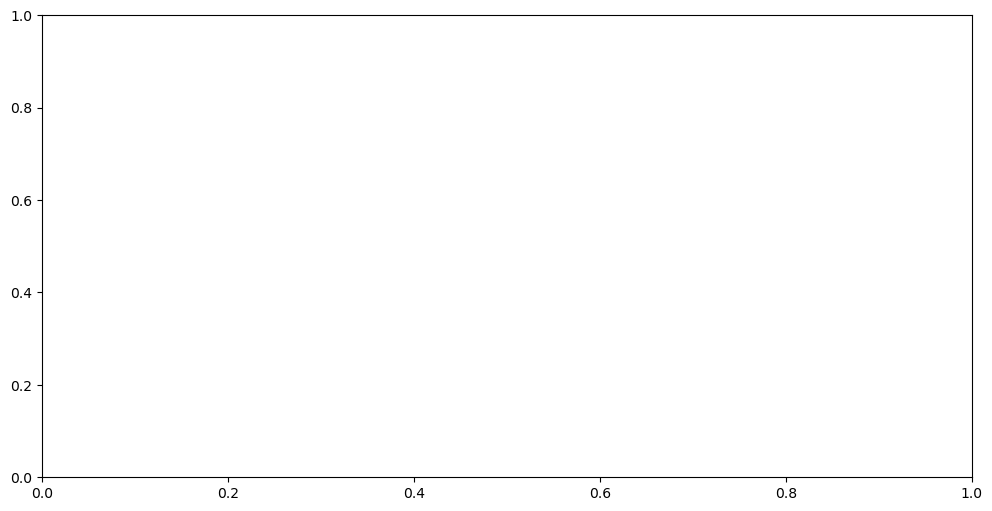

In [102]:

kc12=0.1
kc21=2
Fnoise=0.01
scale=0.25
offset=-0.4
kco1=0.5
koc2=0.25
ko12=1
ko21=2 
orig_params=[kc12,kc21,Fnoise,scale, offset,kco1,koc2,ko12,ko21]
plt.figure(figsize=(12, 6))
data = pymc_sim_channel(orig_params, T, dt, source="pymc")
print(dir(data))
plt.plot(data)
plt.title('torch sim Channel Data')

In [87]:
real_data = torch.stack([pymc_sim_channel(orig_params, T, dt) for _ in range(NUM_SAMPLES)], dim=0)

In [88]:
import pymc as pm
import pytensor.tensor as tt
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

def create_model(T, dt, NUM_SAMPLES):
    with pm.Model() as model:
        # Priors for parameters (using transformed distributions to ensure valid ranges)
        kc21 = pm.Beta('kc21', alpha=2, beta=5)
        kc12 = pm.Beta('kc12', alpha=2, beta=5)
        kco1 = pm.Beta('kco1', alpha=2, beta=5)
        koc2 = pm.Beta('koc2', alpha=2, beta=5)
        ko12 = pm.Beta('ko12', alpha=2, beta=5)
        ko21 = pm.Beta('ko21', alpha=2, beta=5)
        Fnoise = pm.HalfNormal('Fnoise', sigma=1)
        scale = pm.HalfNormal('scale', sigma=1)
        offset = pm.Normal('offset', mu=0, sigma=1)

        print("Variables immediately after creation:")
        for var in [kc21, kc12, kco1, koc2, ko12, ko21, Fnoise, scale, offset]:
            print(f"Name: {var.name}, Type: {type(var)}, Has distribution: {hasattr(var, 'distribution')}")
            if hasattr(var, 'distribution'):
                print(f"  Distribution type: {type(var.distribution)}")

        # Placeholder for discriminator probabilities
        discriminator_probs = pm.MutableData('discriminator_probs', np.ones(NUM_SAMPLES) * 0.5)

        # Add a small epsilon to avoid log(0) or log(1)
        epsilon = 1e-7
        safe_probs = tt.clip(discriminator_probs, epsilon, 1 - epsilon)

        # Likelihood based on discriminator probabilities
        likelihood = pm.Potential('likelihood', tt.sum(tt.log(safe_probs)))

        print("\nVariables after adding likelihood:")
        for var in [kc21, kc12, kco1, koc2, ko12, ko21, Fnoise, scale, offset]:
            print(f"Name: {var.name}, Type: {type(var)}, Has distribution: {hasattr(var, 'distribution')}")
            if hasattr(var, 'distribution'):
                print(f"  Distribution type: {type(var.distribution)}")

        # Collect all random variables
        random_vars = [kc21, kc12, kco1, koc2, ko12, ko21, Fnoise, scale, offset]
    
        print("\nRandom variables after model creation:")
        for var in random_vars:
            print(f"Name: {var.name}, Type: {type(var)}, Has distribution: {hasattr(var, 'distribution')}")
            if hasattr(var, 'distribution'):
                print(f"  Distribution type: {type(var.distribution)}")
        prior_predictive = pm.sample_prior_predictive(samples=1000)
    
        return model, prior_predictive
# Usage
model, prior_predictive = create_model(T, dt, NUM_SAMPLES)
print("\nModel created successfully!")

print("\nChecking distributions from prior predictive:")
for var_name, value in prior_predictive.prior.items():
    if var_name != 'discriminator_probs':
        print(f"Variable: {var_name}")
        print(f"  Shape: {value.shape}")
        print(f"  Mean: {value.mean():.4f}")
        print(f"  Std: {value.std():.4f}")
        print(f"  Min: {value.min():.4f}")
        print(f"  Max: {value.max():.4f}")

/var/folders/_n/b_grcm9j7pd5hrdkdnkl728m0000gn/T/ipykernel_61258/966398202.py:50: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  prior_predictive = pm.sample_prior_predictive(samples=1000)
Sampling: [Fnoise, kc12, kc21, kco1, ko12, ko21, koc2, offset, scale]


Variables immediately after creation:
Name: kc21, Type: <class 'pytensor.tensor.variable.TensorVariable'>, Has distribution: False
Name: kc12, Type: <class 'pytensor.tensor.variable.TensorVariable'>, Has distribution: False
Name: kco1, Type: <class 'pytensor.tensor.variable.TensorVariable'>, Has distribution: False
Name: koc2, Type: <class 'pytensor.tensor.variable.TensorVariable'>, Has distribution: False
Name: ko12, Type: <class 'pytensor.tensor.variable.TensorVariable'>, Has distribution: False
Name: ko21, Type: <class 'pytensor.tensor.variable.TensorVariable'>, Has distribution: False
Name: Fnoise, Type: <class 'pytensor.tensor.variable.TensorVariable'>, Has distribution: False
Name: scale, Type: <class 'pytensor.tensor.variable.TensorVariable'>, Has distribution: False
Name: offset, Type: <class 'pytensor.tensor.variable.TensorVariable'>, Has distribution: False

Variables after adding likelihood:
Name: kc21, Type: <class 'pytensor.tensor.variable.TensorVariable'>, Has distributio

In [89]:
def generate_synthetic_data(inference_data, num_samples, T, dt):
    # Extract parameters from the InferenceData object
    params = {var: inference_data.prior[var].values.flatten() for var in inference_data.prior.data_vars}
    
    synthetic_data = []
    for i in range(num_samples):
        # Randomly select a set of parameters
        sample_params = [np.random.choice(params[var]) for var in ['kc12', 'kc21', 'Fnoise', 'scale', 'offset', 'kco1', 'koc2', 'ko12', 'ko21']]
        # Generate a single synthetic data sample
        sample = pymc_sim_channel(sample_params, T, dt, source="torch")
        
        synthetic_data.append(sample)
    
    # Stack all samples into a single tensor
    return torch.stack(synthetic_data).float()

In [90]:
import numpy as np
import xarray as xr
import warnings

def custom_prior_predictive(model, num_samples, discriminator, T, dt):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        with model:
            # Sample from priors
            prior_samples = pm.sample_prior_predictive(samples=num_samples)
    
    print("Prior samples structure:")
    for var_name, var_data in prior_samples.prior.items():
        print(f"{var_name}: shape = {var_data.shape}, dtype = {var_data.dtype}")
    
    # Generate synthetic data
    synthetic_data = []
    for i in range(num_samples):
        sample_params = []
        for var in model.free_RVs:
            param = prior_samples.prior[var.name]
            if isinstance(param, xr.DataArray):
                sample_params.append(param.values[0, i])
            elif isinstance(param, np.ndarray):
                sample_params.append(param[0, i])
            else:
                sample_params.append(param)
        
        sample = pymc_sim_channel(sample_params, T, dt, source="torch")
        synthetic_data.append(sample)
    
    synthetic_data = torch.stack(synthetic_data).float()
    
    # Get discriminator probabilities
    with torch.no_grad():
        disc_probs = torch.sigmoid(discriminator(synthetic_data)).numpy()
    
    return prior_samples, disc_probs

# Usage
prior_samples, disc_probs = custom_prior_predictive(model, NUM_SAMPLES, discriminator, T, dt)

Sampling: [Fnoise, kc12, kc21, kco1, ko12, ko21, koc2, offset, scale]


Prior samples structure:
koc2: shape = (1, 100), dtype = float64
ko21: shape = (1, 100), dtype = float64
ko12: shape = (1, 100), dtype = float64
Fnoise: shape = (1, 100), dtype = float64
kc21: shape = (1, 100), dtype = float64
kc12: shape = (1, 100), dtype = float64
scale: shape = (1, 100), dtype = float64
offset: shape = (1, 100), dtype = float64
kco1: shape = (1, 100), dtype = float64


/Users/rbj/miniconda3/envs/metal_102/lib/python3.9/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/rbj/miniconda3/envs/metal_102/lib/python3.9/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Users/rbj/miniconda3/envs/metal_102/lib/python3.9/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Users/rbj/miniconda3/envs/metal_102/lib/python3.9/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")

        mean   sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
offset   0.0  0.0     0.0      0.0        0.0      0.0     740.0     740.0   
kc21     0.2  0.0     0.2      0.2        0.0      0.0     740.0     740.0   
kc12     0.2  0.0     0.2      0.2        0.0      0.0     740.0     740.0   
kco1     0.2  0.0     0.2      0.2        0.0      0.0     740.0     740.0   
koc2     0.2  0.0     0.2      0.2        0.0      0.0     740.0     740.0   
ko12     0.2  0.0     0.2      0.2        0.0      0.0     740.0     740.0   
ko21     0.2  0.0     0.2      0.2        0.0      0.0     740.0     740.0   
Fnoise   0.0  0.0     0.0      0.0        0.0      0.0     740.0     740.0   
scale    0.0  0.0     0.0      0.0        0.0      0.0     740.0     740.0   

        r_hat  
offset    NaN  
kc21      NaN  
kc12      NaN  
kco1      NaN  
koc2      NaN  
ko12      NaN  
ko21      NaN  
Fnoise    NaN  
scale     NaN  


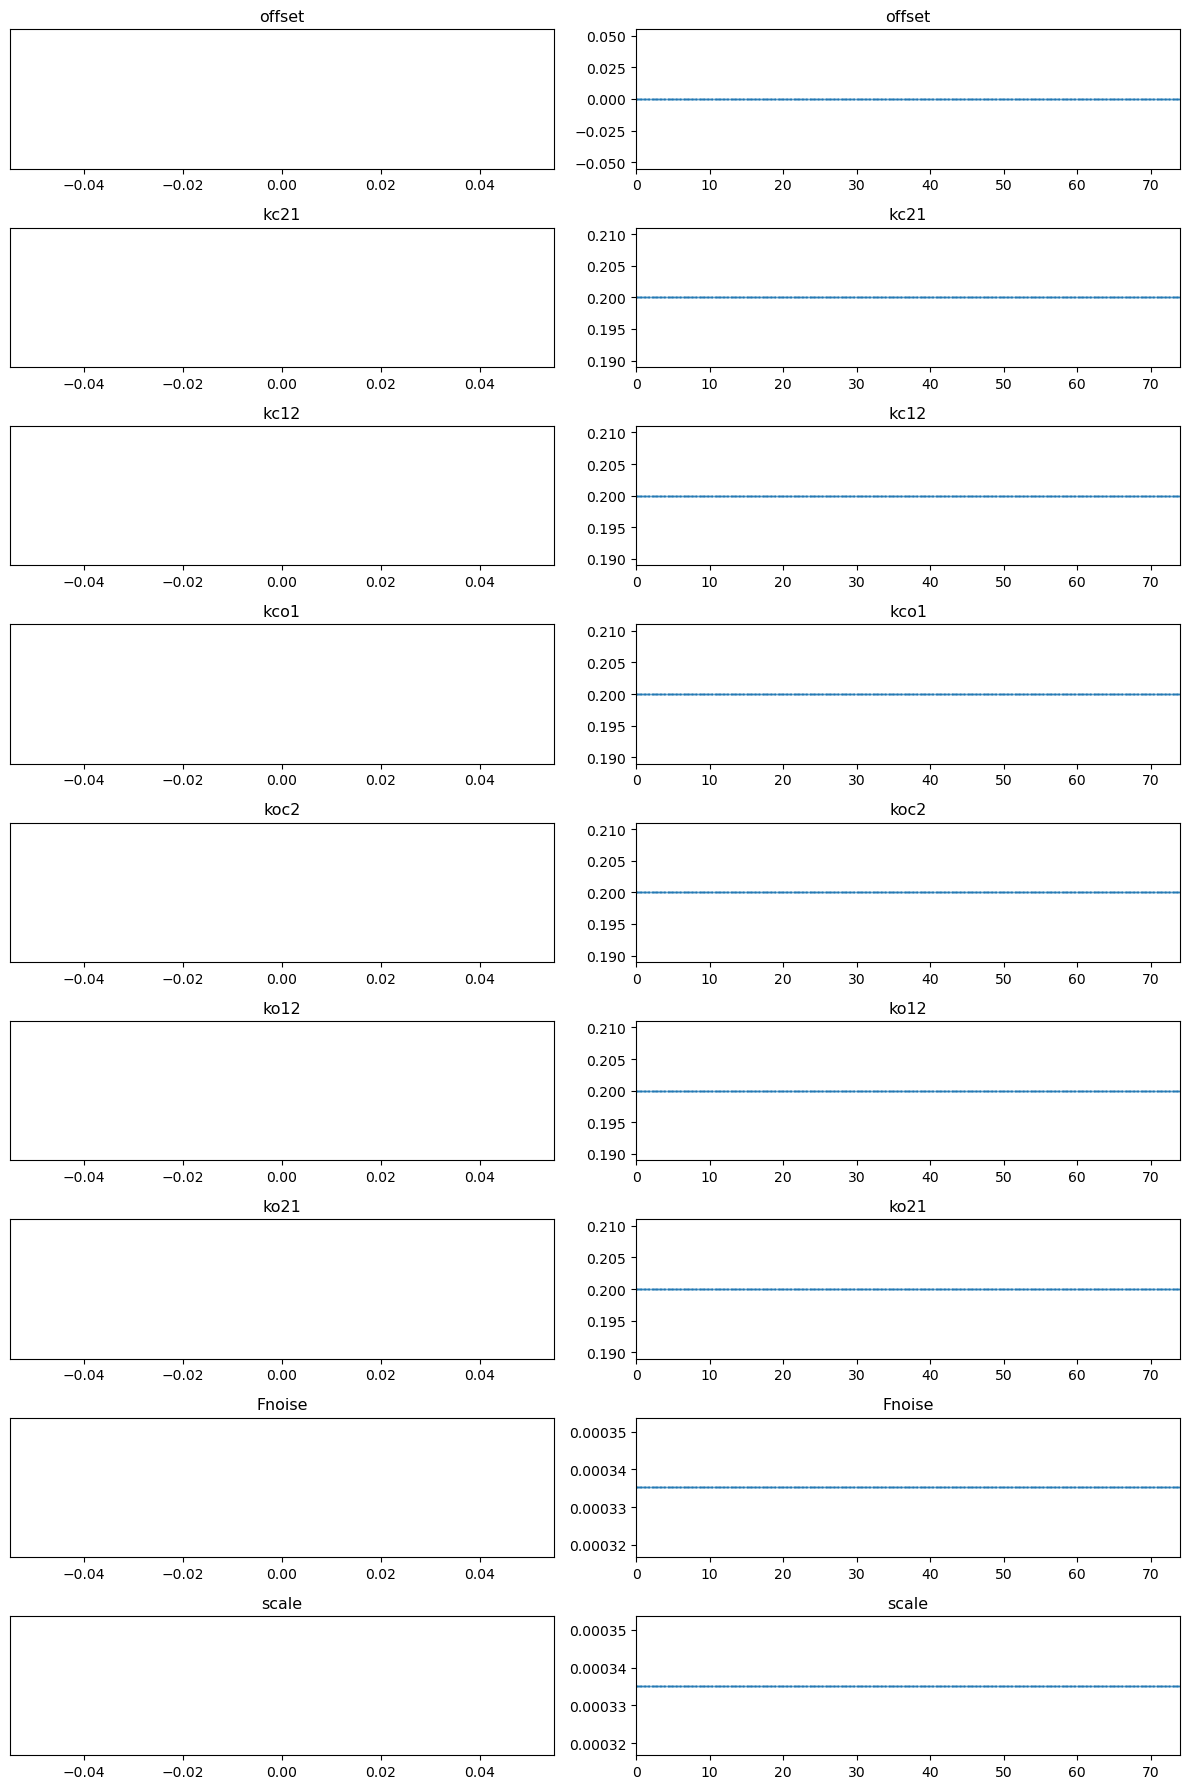

/Users/rbj/miniconda3/envs/metal_102/lib/python3.9/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


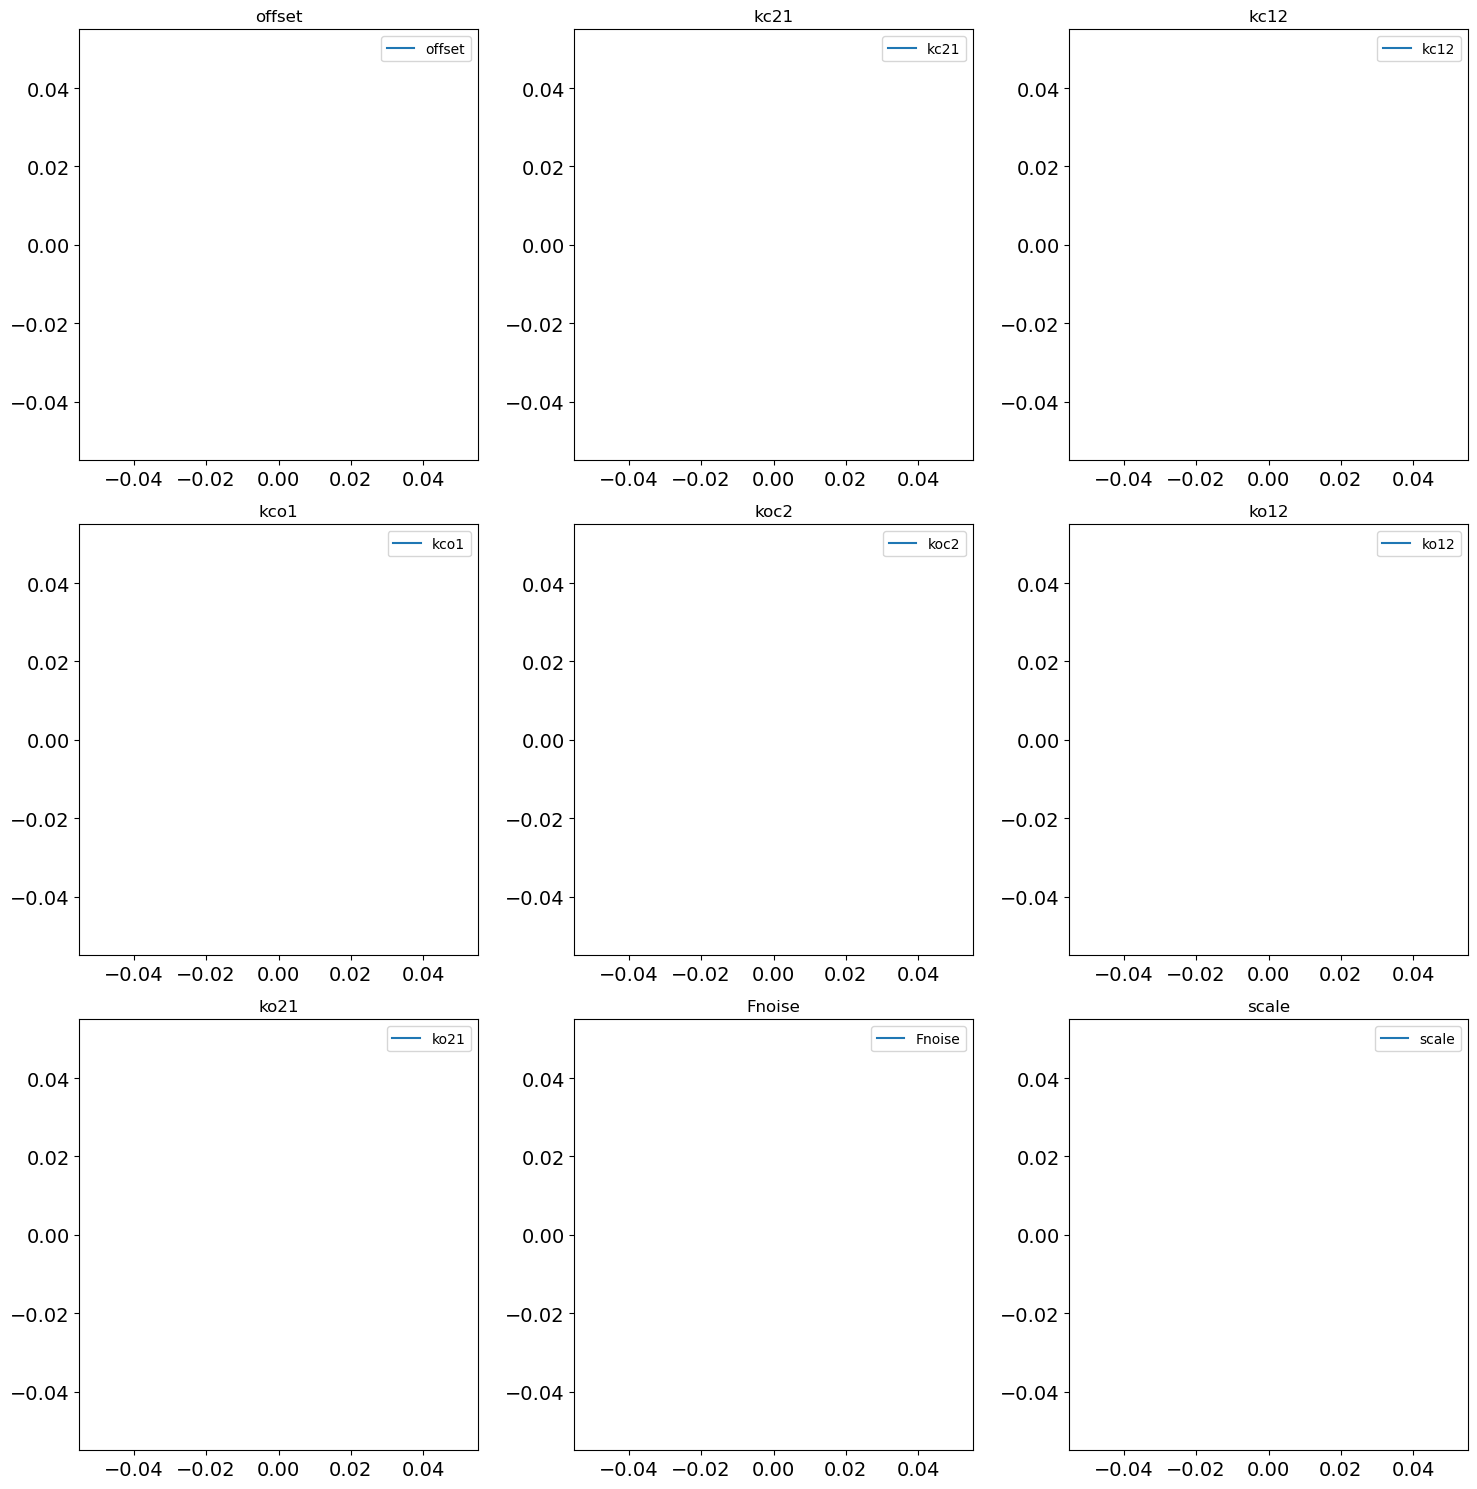

  0%|▌                                                                                                      | 5/1000 [11:12:37<3662:45:37, 13252.20s/it]/var/folders/_n/b_grcm9j7pd5hrdkdnkl728m0000gn/T/ipykernel_61258/3083289835.py:29: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  prior_predictive = pm.sample_prior_predictive(samples=NUM_SAMPLES)
Sampling: [Fnoise, kc12, kc21, kco1, ko12, ko21, koc2, offset, scale]



Epoch 6/1000
Discriminator Loss: 1.209007978439331


/var/folders/_n/b_grcm9j7pd5hrdkdnkl728m0000gn/T/ipykernel_61258/3083289835.py:57: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  trace = pm.sample(50, step=custom_step, chains=2,
Only 50 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [kc12]
>Metropolis: [kc21]
>Metropolis: [Fnoise]
>Metropolis: [scale]
>Metropolis: [offset]
>Metropolis: [kco1]
>Metropolis: [koc2]
>Metropolis: [ko12]
>Metropolis: [ko21]


  0%|▌                                                                                                       | 5/1000 [11:13:44<2234:33:33, 8084.84s/it]

Error in MCMC sampling: Not enough samples to build a trace.
Traceback for MCMC sampling:
Traceback (most recent call last):
  File "/var/folders/_n/b_grcm9j7pd5hrdkdnkl728m0000gn/T/ipykernel_61258/3083289835.py", line 57, in train
    trace = pm.sample(50, step=custom_step, chains=2,
  File "/Users/rbj/miniconda3/envs/metal_102/lib/python3.9/site-packages/pymc/sampling/mcmc.py", line 826, in sample
    return _sample_return(
  File "/Users/rbj/miniconda3/envs/metal_102/lib/python3.9/site-packages/pymc/sampling/mcmc.py", line 857, in _sample_return
    traces, length = _choose_chains(traces, tune)
  File "/Users/rbj/miniconda3/envs/metal_102/lib/python3.9/site-packages/pymc/backends/base.py", line 595, in _choose_chains
    raise ValueError("Not enough samples to build a trace.")
ValueError: Not enough samples to build a trace.



AttributeError: 'tuple' object has no attribute 'tb_frame'

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x10628b400>>
Traceback (most recent call last):
  File "/Users/rbj/miniconda3/envs/metal_102/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


In [91]:
import sys
class StepSkipException(Exception):
    pass


traces = []

def print_error(section, e):
    print(f"Error in {section}: {str(e)}")
    print(f"Traceback for {section}:")
    import traceback
    print(traceback.format_exc())
import numpy as np
import torch
import torch.nn as nn
import pymc as pm
import arviz as az
import pytensor.tensor as at
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output

def train(epoch):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    
    with model:
        try:
            # Generate synthetic data using current model state
            prior_predictive = pm.sample_prior_predictive(samples=NUM_SAMPLES)
            synthetic_data = generate_synthetic_data(prior_predictive, NUM_SAMPLES, T, dt)
        except Exception as e:
            print_error("synthetic data generation", e)
            sys.exit(1)
            raise StepSkipException(f"Error in synthetic data generation step: {str(e)}")
        
        try:
            # Train discriminator
            real_output = discriminator(real_data)
            fake_output = discriminator(synthetic_data)
            disc_loss = discriminator_loss(real_output, fake_output)
            discriminator_optimizer.zero_grad()
            disc_loss.backward()
            
            discriminator_optimizer.step()
            print(f"Discriminator Loss: {disc_loss.item()}")
        except Exception as e:
            print_error("discriminator training", e)
            sys.exit(1)
            raise StepSkipException(f"Error in discriminator training step: {str(e)}")
    
        try:
            start = pm.find_MAP()
            # Perform MCMC with custom step method
            custom_step = CustomGANStep(model=model, 
                                        discriminator=discriminator, T=T, dt=dt, debug=False)

            trace = pm.sample(50, step=custom_step, chains=2, 
                      tune=25, cores=2, return_inferencedata=True, start=start)
            traces.append(trace)
        except Exception as e:
            print_error("MCMC sampling", e)
            sys.exit(1)
            raise StepSkipException(f"Error in MCMC sampling step: {str(e)}")
    
        try:
            # Print progress
            if len(traces) > 1:
                combined_trace = az.concat(traces, dim="chain")
            else:
                combined_trace = traces[0]
            clear_output(wait=True)
            summary = az.summary(combined_trace)
            print(summary)
            
            # Plot traces
            az.plot_trace(combined_trace)
            plt.tight_layout()
            plt.show()
            
            # Plot parameter distributions
            fig, axes = plt.subplots(3, 3, figsize=(15, 15))
            axes = axes.flatten()
            for i, (var_name, values) in enumerate(combined_trace.posterior.items()):
                if var_name != 'discriminator_probs':
                    az.plot_dist(values, ax=axes[i], label=var_name)
                    axes[i].set_title(var_name)
                    axes[i].legend()
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print_error("summary and plotting", e)
            sys.exit(1)
            raise StepSkipException(f"Error in summary and plotting step: {str(e)}")

# Main training loop
traces = []

print(f"Model variables: {[var.name for var in model.free_RVs]}")

for epoch in tqdm(range(EPOCHS)):
    try:
        train(epoch)
    except StepSkipException as e:
        print(f"Skipping epoch due to error: {str(e)}")
        continue

# After training, analyze the results
try:
    if len(traces) > 1:
        final_trace = az.concat(traces, dim="chain")
    else:
        final_trace = traces[0]
    az.plot_trace(final_trace)
    plt.show()
    
    # Print final summary
    final_summary = az.summary(final_trace)
    print("Final model summary:")
    print(final_summary)
    
    # Plot final parameter distributions
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    axes = axes.flatten()
    for i, (var_name, values) in enumerate(final_trace.posterior.items()):
        if var_name != 'discriminator_probs':
            az.plot_dist(values, ax=axes[i], label=var_name)
            axes[i].set_title(var_name)
            axes[i].legend()
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print_error("final analysis", e)
print(f"Model variables: {[var.name for var in random_vars]}")

for epoch in tqdm(range(EPOCHS)):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    train(epoch)

# After training, analyze the results
try:
    if len(traces) > 1:
        final_trace = az.concat(traces, dim="chain")
    else:
        final_trace = traces[0]
    az.plot_trace(final_trace)
    plt.show()
except Exception as e:
    print_error("plotting traces", e)

In [ ]:
az.plot_trace(trace)


In [ ]:
model['kco2']

In [ ]:
type(model['kc12'])